# PID Controller Matching

In this notebook we will demonstrate how we went about matching 66% of the test data by inverting PID controllers. Most of the `u_in` trajectories in the data were sampled according to a PID controller and the pressure is quite deterministic as the lung used for testing was mechanical. Therefore, if we can find pressure values that, when plugged into the PID formulas, perfectly calculate to our provided `u_in`, we have a perfect match.

A PID controller is used in physical system to manipulate a controllable variable in order to keep another measureable variable around a certain target value. In our case, `u_in` is the controllable variable and `pressure` is the measureable variable. The "vanilla" formula of a PID (Proportional - Integral - Derivative) controller can be found in [the paper of the organizers](https://arxiv.org/pdf/2102.06779.pdf) in section 2:

$u_t = \alpha \epsilon_t + \beta \sum^k_{i=0}\epsilon_{t-i} + \gamma(\epsilon_t - \epsilon_{t-1})$

Here, $u_t$ is the controllable variable and corresponds to the `u_in` value at time $t$. $\epsilon_t$ corresponds to the **Proportional** term and is equal to $target - p_t$ with $p_t$ the `pressure` at time $t$. $\sum^k_{i=0}\epsilon_{t-i}$ corresponds to the **Integral** term and $\epsilon_t - \epsilon_{t-1}$ the **Derivative** term. $target, \alpha, \beta, \gamma$ are tuneable parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import mode
from collections import defaultdict
import itertools
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings; warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv', index_col=['id'])
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv', index_col=['id'])

In [3]:
MAX_PRESSURE  = PRESSURE_MAX  = 64.82099173863328
MIN_PRESSURE  = PRESSURE_MIN  = -1.895744294564641
DIFF_PRESSURE = PRESSURE_STEP = 0.0703021454512
MIN_PRESSURE2 = PRESSURE_MIN2 = MIN_PRESSURE + DIFF_PRESSURE

In [4]:
# We will be filling our matches in a submission that scores CV=0.1406 (single LSTM model)
# You can plug in your own submission here as well.
train_preds = pd.read_csv('../input/ventilator-foggy/oofs_foggy_0.1406.csv', index_col=['id'])
test_preds = pd.read_csv('../input/ventilator-foggy/pred_foggy_0.1406.csv', index_col=['id'])

In [5]:
print(f'MAE = {mean_absolute_error(train[train["u_out"] == 0]["pressure"], train_preds[train["u_out"] == 0]["pressure"])}')

MAE = 0.14066919317901422


# 1. P-Controllers

Let us first take a look at the easiest case: PID Controllers with `I = 0` and `D = 0`. The formula from above simplifies to:

$u_t = \alpha \epsilon_t$

This is just a 1-dimensional Linear Regression model with $u_t$ the dependent variable, $\epsilon_t = target - p_t$ the dependent variable and $alpha$ the only weight of our 1D model. However, we are interested in predicting $p_t$ and not $u_t$, so let's rewrite this equation:

$u_t = \alpha (target - p_t) \iff \frac{u_t}{\alpha} = target - p_t \iff p_t = target - \frac{u_t}{\alpha}$.

$\alpha$ and $target$ are tunable parameters. **In this competition, there are only a discrete number of possibilities for these parameters.** There are two ways to find these: 
* yeet them from the appendix of the paper 
* Run the commented code below, which fits linear regression models using training pressure & u_in. It takes roughly 10 minutes.

**Important note:** both the first value and all values of the expiratory phase of every breath are noisy. Discard these!

In [6]:
# kts, kps = set(), set()
# for breath in tqdm(train['breath_id'].unique()):
#     breath_df = train[train['breath_id'] == breath]
#     in_len = np.sum(1 - breath_df['u_out'].values)
#     X = breath_df['u_in'].values[1:in_len].reshape((-1, 1))
#     y = breath_df['pressure'].values[1:in_len]

#     lr = LinearRegression()
#     lr.fit(X, y)
#     if lr.score(X, y) > 0.9999:
#         print(lr.intercept_, lr.coef_[0])
#         kts.add(lr.intercept_)
#         kps.add(lr.coef_[0])

## Parameters

The parameters are the following:

* $\alpha$, or referred to as $k_p$ in the code: $[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]$
* $target$, or referred to as $k_t$ in the code: $[10, 15, 20, 25, 30, 35]$

PS: $\beta$ will have the same possible parameter values later on.

Let's show the matching on one breath.

Found match! 25 0.8


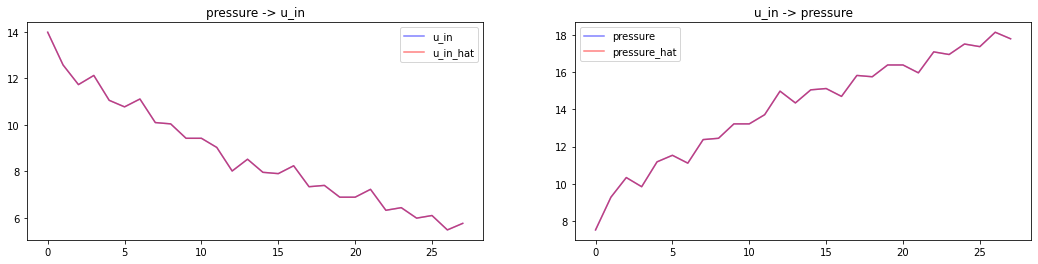

In [7]:
breath = train[train['breath_id'] == 2]
in_len = np.sum(1 - breath['u_out'])
pressure = breath['pressure'].values[1:in_len]
u_in = breath['u_in'].values[1:in_len]

found_kt, found_kp = None, None
for kt in [10, 15, 20, 25, 30, 35]:
    for kp in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]:
        u_in_pred = kp * (kt - pressure)
        if np.sum(np.abs(u_in - u_in_pred)) < 1e-10:
            print('Found match!', kt, kp)
            found_kt = kt
            found_kp = kp
            
f, ax = plt.subplots(1, 2, figsize=(18, 4))
ax[0].plot(u_in, c='b', alpha=0.5, label='u_in')
ax[0].plot(found_kp * (found_kt - pressure), c='r', alpha=0.5, label='u_in_hat')
ax[0].legend()
ax[0].set_title('pressure -> u_in')

ax[1].plot(pressure, c='b', alpha=0.5, label='pressure')
ax[1].plot(found_kt - (u_in / found_kp), c='r', alpha=0.5, label='pressure_hat')
ax[1].legend()
ax[1].set_title('u_in -> pressure')

plt.show()

## Matching algorithm

However, we used pressure for this code. Of course, we do not have pressures for our test data. We are still able to do our matching by exploiting the discrete nature of the pressure values. If we are able to find a $k_t$ and $k_p$ parameter such that our formula calculates to values that perfectly align with the discrete pressure values, we have a match. The alignment with the discrete pressure values can be calculated as follows:

$p_{ROUND} = \frac{\hat{p} - p_{MIN}}{p_{STEP}}$

$error = \sum | \lfloor p_{ROUND} + 0.5 \rfloor - p_{ROUND} |$

With $\lfloor p_{ROUND} + 0.5 \rfloor$ a rounding operator (`np.round(.)`)

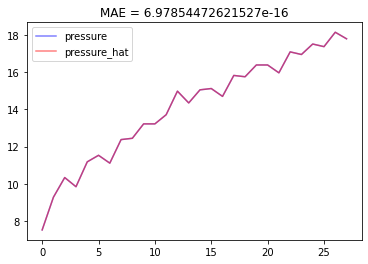

In [8]:
def match_breath(breath):
    u_in = breath['u_in'].values
    inspiratory_len = np.sum(1 - breath['u_out'])
    
    u_in = u_in[1:inspiratory_len]
    breath_mask = (u_in > 0) & (u_in < 100)
    
    if np.sum(breath_mask) < 2:
        return None, None, None, None
        
    for kt in [10, 15, 20, 25, 30, 35]:
        for kp in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]:
            preds = (kt - u_in / kp)
            preds_round = (preds-MIN_PRESSURE)/DIFF_PRESSURE
            tune_error = np.sum(np.abs(np.round(preds_round[breath_mask]) - 
                                       preds_round[breath_mask]))
            if tune_error < 1e-6:
                return preds, kt, kp, breath_mask
            
    return None, None, None, None

breath = train[train['breath_id'] == 2]
preds, kt, kp, mask = match_breath(breath)
pressure = breath['pressure'].values[1:in_len]

plt.figure()
plt.plot(pressure[mask], c='b', alpha=0.5, label='pressure')
plt.plot(preds[mask], c='r', alpha=0.5, label='pressure_hat')
plt.title(f'MAE = {np.mean(np.abs(preds - pressure))}')
plt.legend()
plt.show()

Let's run this on all our training data to see what the impact is. **I pre-calculated a list of matches to make the notebook run quicker. Of course you can just remove this and let it run over the entire data.**

In [9]:
matches = pickle.load(open('../input/ventilator-foggy/p_controller_train_matches.p', 'rb'))

In [10]:
train_preds_2 = train_preds.copy()

for breath_id in tqdm(train['breath_id'].unique()):
    if breath_id not in matches:
        continue
        
    breath = train[train['breath_id'] == breath_id]
    preds, kt, kp, mask = match_breath(breath)
    ids = breath.index.values[1:1+len(preds)]
          
    if preds is not None:
        train_preds_2.loc[ids[mask], 'pressure'] = preds[mask]

  0%|          | 0/75450 [00:00<?, ?it/s]

In [11]:
print(f'MAE = {mean_absolute_error(train[train["u_out"] == 0]["pressure"], train_preds_2[train["u_out"] == 0]["pressure"])}')

MAE = 0.13594633279955307


**Here's a nice little trick. If we make a cocky assumption that all of our matches are perfect and correct, you can estimate your MAE locally by calculating the difference between the old submission and the new submission.**

In [12]:
mae1 = mean_absolute_error(train[train["u_out"] == 0]["pressure"], train_preds[train["u_out"] == 0]["pressure"])
mae2 = mean_absolute_error(train[train["u_out"] == 0]["pressure"], train_preds_2[train["u_out"] == 0]["pressure"])
print(f'MAE diff = {mae1 - mae2}')
print(f'MAE = {mean_absolute_error(train_preds[train["u_out"] == 0]["pressure"], train_preds_2[train["u_out"] == 0]["pressure"])}')

MAE diff = 0.004722860379461152
MAE = 0.004722860379461166


# 2. PI-Controllers

The integral is calculated by a moving average with decay. This is not the usual implementation of a PID controller, and is the reason why it took us that long to get it working.

The formula can be found [in this presentation](https://robotics.sjtu.edu.cn/upload/course/1/files/Lecture%2010%20PID-2(1).pdf) on slide 26, or in the [source code of the lung they used](https://github.com/CohenLabPrinceton/pvp/blob/master/pvp/controller/control_module.py).

We will rewrite $\sum^k_{i=0}\epsilon_{t-i}$ as $I_t$:

$I_t = I_{t - 1} + (\epsilon_t - I_{t - 1}) \frac{\Delta_t}{\tau + \Delta_t}$

with $\Delta_t = time_{t} - time_{t - 1}$ and $\tau$ a constant equal to $0.5$. Since we now have an integral term, we also have to tune $\beta$, or referred to as $k_i$ in the code, which can take the same values as $\alpha$.

Let's take a look at a training breath again and how we are able to model `pressure -> u_in` perfectly using this formula on some breaths.

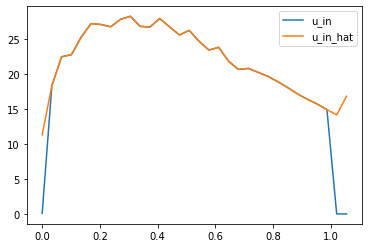

In [13]:
def generate_u_in(pressure, time_step, kp, ki, kt, integral=0):
    dt = np.diff(time_step, prepend=[0])
    preds = []
    for j in range(32):
        error = kt - pressure[j]
        integral += (error - integral) * (dt[j] / (dt[j] + 0.5))
        preds.append(kp * error + ki * integral)
    return preds

pressure = train[train['breath_id'] == 1]['pressure'].values 
timestep = train[train['breath_id'] == 1]['time_step'].values
# The parameters below (0.8, 8.0 and 20) can be found by doing a grid search
# over all 2400 possible values and finding the parameters with minimal error.
u_in = generate_u_in(pressure, timestep, 0.8, 8.0, 20)
noise = train[train['breath_id'] == 1]['u_in'].values[:32] - u_in

plt.figure()
plt.plot(timestep[:32], train[train['breath_id'] == 1]['u_in'].values[:32], label='u_in')
plt.plot(timestep[:32], u_in, label='u_in_hat')
plt.legend()
plt.show()

## Matching algorithm

Now unfortunately, this does not work on all breaths. We hypothesize that this is because integral is not always initialized to $0$. 

Luckily, we can rework our equations a bit to isolate the integral at any point in time. This avoids us having to propagate from the beginning of the signal to the timestep we want to predict. Instead, we can just calculate the integral of the previous timestep using our `u_in` and predicted `pressure` and propagate from there.

$u_t = \alpha \epsilon_t + \beta I_t \iff I_t = \frac{u_t - \alpha \epsilon_t}{\beta}$

Now our matching algorithm goes as follows:

1. Assume we want to fill in the pressure for timestep `t`
2. Take two random pressure values (from the 950 possible options). Let's call them `P0` and `P1`
3. Also take a possible parameter combination (20 options for kp, 20 options for ki and 6 options for kt --> 2400 combinations)
4. Calculate `dt = time_step[t] - time_step[t - 1]`
4. Calculate `I0 = (u_in[t - 1] - kp * (kt - P0))/ki`
5. Calculate `I1 = I0 + (kt - P1 - I0) * (dt / (dt + 0.5))`
7. Calculate `u_in_hat[t] = kp * (kt - P1) + ki * I1`
8. If `u_in_hat[t] == u_in[t]` we can fill in P1 for `pressure[t]`

In [14]:
#Let's try this for 1 specific breath & timestep.
# Notice how we are only using pressure to check our results! So this works on test breaths too.
pressure   = train[train['breath_id'] == 1]['pressure'].values 
timestep   = train[train['breath_id'] == 1]['time_step'].values
u_in       = train[train['breath_id'] == 1]['u_in'].values
kp, ki, kt = 0.8, 8.0, 20
t = 5
dt = timestep[t] - timestep[t - 1]

In [15]:
%%time

for P0 in np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE):
    for P1 in np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE):
        I0 = (u_in[t - 1] - kp * (kt - P0))/ki
        I1 = I0 + (kt - P1 - I0) * (dt / (dt + 0.5))
        u_in_hat = kp * (kt - P1) + ki * I1
        if abs(u_in_hat - u_in[t]) < 1e-8:
            print(P0, P1, pressure[t-1:t+1])

12.23498694112657 12.867706250187371 [12.23498694 12.86770625]
CPU times: user 2.95 s, sys: 5.91 ms, total: 2.96 s
Wall time: 2.95 s


## 1000x speedup

That looks like a good match! Now unfortunately, this algorithm is really slow. If we take into account the grid search, we have `20*20*6*950*950` possible combinations to try out... If we fix our parameters, we have `950*950` combinations and we see that this already takes 6 seconds... However, we can speed this up by a factor of 950! Moreover, once we found a pressure for timestep `t` we can re-use this to calculate timestep `t + 1`, so that's another 950 speedup for the timesteps after that.

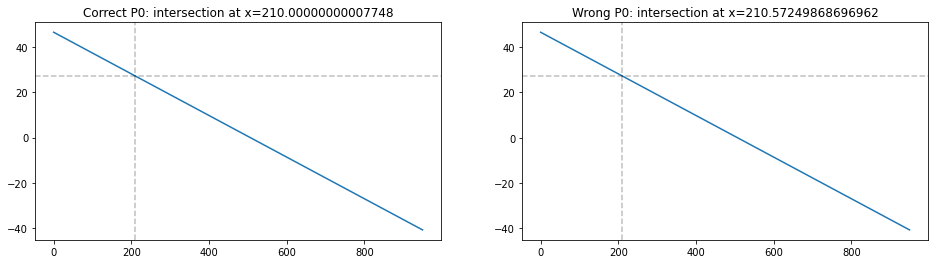

In [16]:
# Let's fix our P0 and let's take a look at how our u_in predictions evolve across every iteration.
# We will compare this to when P0 is wrong.
P0 = pressure[t - 1]

u_in_preds1 = []
for P1 in np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE):
    I0 = (u_in[t - 1] - kp * (kt - P0))/ki
    I1 = I0 + (kt - P1 - I0) * (dt / (dt + 0.5))
    u_in_hat = kp * (kt - P1) + ki * I1
    u_in_preds1.append(u_in_hat)
    
P0 = pressure[t - 1] + DIFF_PRESSURE

u_in_preds2 = []
for P1 in np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE):
    I0 = (u_in[t - 1] - kp * (kt - P0))/ki
    I1 = I0 + (kt - P1 - I0) * (dt / (dt + 0.5))
    u_in_hat = kp * (kt - P1) + ki * I1
    u_in_preds2.append(u_in_hat)
    
f, ax = plt.subplots(1, 2, figsize=(16, 4))
slope1 = u_in_preds1[1] - u_in_preds1[0]
x_intersection1 = (u_in[t] - u_in_preds1[0])/slope1
ax[0].plot(u_in_preds1)
ax[0].axhline(u_in[t], c='k', linestyle='--', alpha=0.25)
ax[0].axvline(x_intersection1, c='k', linestyle='--', alpha=0.25)
ax[0].set_title(f'Correct P0: intersection at x={x_intersection1}')

slope2 = u_in_preds2[1] - u_in_preds2[0]
x_intersection2 = (u_in[t] - u_in_preds2[0])/slope2
ax[1].plot(u_in_preds2)
ax[1].axhline(u_in[t], c='k', linestyle='--', alpha=0.25)
ax[1].axvline(x_intersection2, c='k', linestyle='--', alpha=0.25)
ax[1].set_title(f'Wrong P0: intersection at x={x_intersection2}')
plt.show()

**Notice how the x-value where our line intersects is almost perfectly integer. This means we would have bumped into this value during our for-loop (in the 210th iteration)! If it is a floating point, the value is achieved in between iterations and is thus not aligned with discrete pressure values**

In [17]:
%%time
for P0 in np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE):
    I0 = (u_in[t - 1] - kp * (kt - P0))/ki
    
    # Calculate 2 points for P1 so we can get the slope
    I11 = I0 + (kt - MIN_PRESSURE - I0) * (dt / (dt + 0.5))
    u_in_hat1 = kp * (kt - MIN_PRESSURE) + ki * I11
    
    I12 = I0 + (kt - MIN_PRESSURE2 - I0) * (dt / (dt + 0.5))
    u_in_hat2 = kp * (kt - MIN_PRESSURE2) + ki * I12
    
    slope = u_in_hat2 - u_in_hat1
    x_intersect = (u_in[t] - u_in_hat2) / slope
    if abs(np.round(x_intersect) - x_intersect) < 1e-8:
        print(P0, MIN_PRESSURE + (x_intersect + 1) * DIFF_PRESSURE, pressure[t-1:t+1])

12.23498694112657 12.86770625018869 [12.23498694 12.86770625]
CPU times: user 10.5 ms, sys: 157 µs, total: 10.6 ms
Wall time: 10.3 ms


**From 6 seconds to 16 ms, I'll take it!**

In [18]:
ID = 1
pressure   = train[train['breath_id'] == ID]['pressure'].values 
timestep   = train[train['breath_id'] == ID]['time_step'].values
u_in       = train[train['breath_id'] == ID]['u_in'].values
u_out      = train[train['breath_id'] == ID]['u_out'].values

In [19]:
def match_breath(u_in, u_out, timestep, kp, ki, kt):
    dt = np.diff(timestep)
    dt2 = dt / (dt + 0.5)
    in_len = np.sum(1 - u_out)
    preds = np.zeros(len(u_in)) - 999
    
    for t in range(1, in_len):
        # If we had a match in previous timestep, we can re-use that match
        if preds[t - 1] != -999:
            P0 = preds[t - 1]
        else:
            P0 = np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE)
            
        I0 = (u_in[t - 1] - kp * (kt - P0))/ki

        # Calculate 2 points for our P1
        I11 = I0 + (kt - MIN_PRESSURE - I0) * dt2[t-1]
        u_in_hat1 = kp * (kt - MIN_PRESSURE) + ki * I11

        I12 = I0 + (kt - MIN_PRESSURE2 - I0) * dt2[t-1]
        u_in_hat2 = kp * (kt - MIN_PRESSURE2) + ki * I12

        # Get slope and intersection point
        slope = u_in_hat2 - u_in_hat1
        x_intersect = (u_in[t] - u_in_hat2) / slope
        
        # We want the intersection to be an integer
        diff = np.abs(np.round(x_intersect) - x_intersect)
        
        if diff.min() < 1e-10:
            pos = np.argmin(diff)
            
            if preds[t - 1] == -999:
                preds[t - 1] = P0[np.argmin(diff)]
                preds[t] = MIN_PRESSURE + int(x_intersect[pos] + 1) * DIFF_PRESSURE
            else:
                preds[t] = MIN_PRESSURE + (np.round(x_intersect) + 1) * DIFF_PRESSURE
            
    return preds

In [20]:
%%time
preds = match_breath(u_in, u_out, timestep, 0.8, 8.0, 20)

CPU times: user 915 µs, sys: 0 ns, total: 915 µs
Wall time: 922 µs


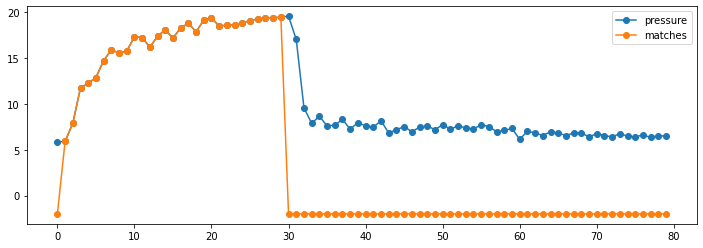

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds), '-o', label='matches')
plt.legend()
plt.show()

In [22]:
mask = preds != -999
print('MATCHED MAE =', mean_absolute_error(pressure[:len(preds)][mask], preds[mask]))
print(f'MATCHES: {np.sum(mask)}')

MATCHED MAE = 4.231373871977573e-12
MATCHES: 29


# 3. I-Controllers

When the optimal `kp` parameter is $0$, a few issues arise. If we look at our brute-force matching code with `kp=0`:
```python
I0 = (u_in[t - 1] - 0 * (kt - P0))/ki
I1 = I0 + (kt - P1 - I0) * (dt / (dt + 0.5))
u_in_hat = 0 * (kt - P1) + ki * I1
```

Which basically becomes:
```python
I0 = u_in[t - 1] / ki
I1 = I0 + (kt - P1 - I0) * (dt / (dt + 0.5))
u_in_hat = ki * I1
```

Which no longer depends on `P0`. Our code will thus find a match for any `P0`. We have not been able to fix this entirely and we decided to sacrifice some matches here as a quick solution.

In [23]:
# Let's demonstrate the issue on a breath with optimal kp = 0
ID = 4
pressure   = train[train['breath_id'] == ID]['pressure'].values 
timestep   = train[train['breath_id'] == ID]['time_step'].values
u_in       = train[train['breath_id'] == ID]['u_in'].values
u_out      = train[train['breath_id'] == ID]['u_out'].values

In [24]:
preds = match_breath(u_in, u_out, timestep, 0., 2., 30)

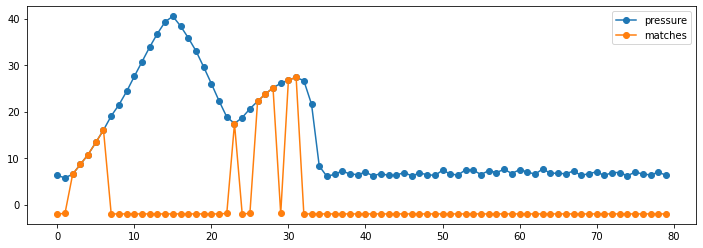

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds), '-o', label='matches')
plt.legend()
plt.show()

In [26]:
mask = preds != -999
print('MATCHED MAE =', mean_absolute_error(pressure[:len(preds)][mask], preds[mask]))

MATCHED MAE = 5.258600479754309


## Quick and dirty solution

So we notice a MAE of $5.25$ now, as there are 4 matches where `PRESSURE_MIN` has been filled in incorrectly. A simple post-processing trick is to remove the matches at the beginning of a sequence of matches when `kp = 0`.

In [27]:
def match_breath(u_in, u_out, timestep, kp, ki, kt):
    dt = np.diff(timestep)
    dt2 = dt / (dt + 0.5)
    in_len = np.sum(1 - u_out)
    preds = np.zeros(len(u_in)) - 999
    
    for t in range(1, in_len):
        # If we had a match in previous timestep, we can re-use that match
#         if preds[t - 1] != -999 and kp > 0:
#             P0 = np.array([preds[t - 1]])
#         else:
        P0 = np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE)
            
        I0 = (u_in[t - 1] - kp * (kt - P0))/ki

        # Calculate 2 points for our P1
        I11 = I0 + (kt - MIN_PRESSURE - I0) * dt2[t-1]
        u_in_hat1 = kp * (kt - MIN_PRESSURE) + ki * I11

        I12 = I0 + (kt - MIN_PRESSURE2 - I0) * dt2[t-1]
        u_in_hat2 = kp * (kt - MIN_PRESSURE2) + ki * I12

        # Get slope and intersection point
        slope = u_in_hat2 - u_in_hat1
        x_intersect = (u_in[t] - u_in_hat2) / slope
        
        # We want the intersection to be an integer
        diff = np.abs(np.round(x_intersect) - x_intersect)
        
        if diff.min() < 1e-10:
            pos = np.argmin(diff)
            
            if preds[t - 1] == -999 and kp > 0 and t > 1:
                preds[t - 1] = P0[np.argmin(diff)]
            preds[t] = MIN_PRESSURE + (np.round(x_intersect[pos]) + 1) * DIFF_PRESSURE
                
    return preds

In [28]:
%%time
preds = match_breath(u_in, u_out, timestep, 0., 2., 30)

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.65 ms


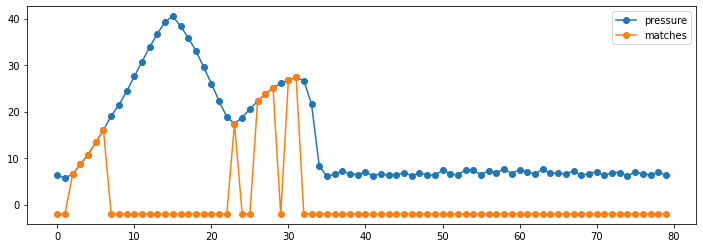

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds), '-o', label='matches')
plt.legend()
plt.show()

In [30]:
mask = preds != -999
print('MATCHED MAE =', mean_absolute_error(pressure[:len(preds)][mask], preds[mask]))

MATCHED MAE = 4.559665776262343e-12


# 4. Removing noise

In section 4.2 of the paper, the organizers discuss two types of noise:

1. A linear decreasing noise starting at a certain value going to 0 added to the beginning of the breath (basically a line going downwards (`\`))
2. Triangular noise starting somewhere in the middle of the breath (`/\` and `\/`)

Let's try to isolate it...

In [31]:
# Let's demonstrate the issue on a breath with optimal kp = 0
ID = 17
pressure   = train[train['breath_id'] == ID]['pressure'].values 
timestep   = train[train['breath_id'] == ID]['time_step'].values
u_in       = train[train['breath_id'] == ID]['u_in'].values
u_out      = train[train['breath_id'] == ID]['u_out'].values
preds = match_breath(u_in, u_out, timestep, 1.0, 3.0, 30)

In [32]:
mask = preds != -999
print('MATCHED MAE =', mean_absolute_error(pressure[:len(preds)][mask], preds[mask]))

MATCHED MAE = 5.368991800854641e-12


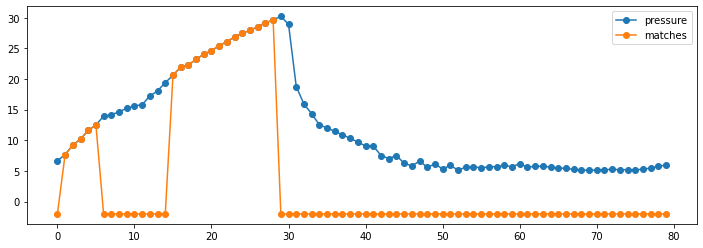

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds), '-o', label='matches')
plt.legend()
plt.show()

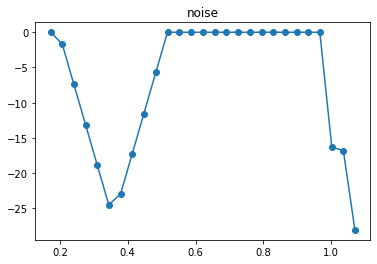

In [34]:
# Let's calculate I_5
def generate_u_in(pressure, time_step, kp, ki, kt, integral=0):
    dt = np.diff(time_step)
    preds = []
    for j in range(32):
        error = kt - pressure[j]
        integral += (error - integral) * (dt[j] / (dt[j] + 0.5))
        preds.append(kp * error + ki * integral)
    return preds

kp, ki, kt = 1., 3., 30
I5 = (u_in[4] - kp * (kt - pressure[4]))/ki
u_in_hat = generate_u_in(pressure[5:], timestep[4:], 1.0, 3.0, 30, integral=I5)
plt.plot(timestep[5:32], u_in[5:32] - u_in_hat[:-5], '-o')
plt.title('noise')
plt.show()

In [35]:
noise = u_in[5:32] - u_in_hat[:-5]
print((np.diff(noise) / np.diff(timestep[5:32]))[:10])

[ -47.80513259 -166.32360291 -166.32360291 -166.32360291 -166.32360291
   44.89316612  166.32360291  166.32360291  166.32360291  165.17598142]


## Forward matching algorithm

While not a perfect triangle, we do notice points that are on the same line in the beginning and ending of our noise (their slopes are nearly identical, and they are the negative of the other half of the triangle). This is the property that we can exploit: assume a sequence of matches followed by a sequence of non-matches starting from index `j` (e.g. starting from index 6 until index 14, we have a sequence of non-matches), from here on we can brute-force 3 new possible future `pressure` values and calculate the `u_in_hat` according to these. Then we can calculate the noise `u_in - u_in_hat`, if the slope between position `j` and `j + 1` is the same as the slope between position `j + 1` and `j + 2`, we are on the triangle and found a match.

1. Start from the last match of a sequence of matches, which is followed by a sequence of non-matched (e.g. index 5 in our breath). `j` is the index of the first non-match (6 here)
2. Calculate `integ1 = (val - kp * (kt - preds[j - 1])) / ki`
3. For every possible combination of (`P2`, `P3`, `P4`) pressure values
4. Calculate `integ2 = integ1 + dt2[j - 1] * (kt - P2 - integ1)` and `u2 = kp * (kt - P2) + ki * integ2`
5. Calculate `integ3 = integ2 + dt2[j + 0] * (kt - P3 - integ2)` and `u3 = kp * (kt - P3) + ki * integ3`
6. Calculate `integ4 = integ3 + dt2[j + 1] * (kt - P4 - integ3)` and `u4 = kp * (kt - P4) + ki * integ4`
7. Calculate `dU = [u_in[j] - u2, u_in[j + 1] - u3, u_in[j + 2] - u4]`
8. If `(dU[1] - dU[0]) / dt[j] == (dU[2] - dU[1]) / dt[j + 1]`, we have a match.

--> Fortunately, we have our `kp`, `ki` and `kt` parameters already found by the previous step, but we do have $950*950*950$ possible combinations. We use the same optimization as before to eliminate one of the parameters and vectorize the other to speed it up.

In [36]:
def match_triangle(u_in, u_out, timestep, preds, kp, ki, kt):
    dt = np.diff(timestep)
    dt2 = dt / (dt + 0.5)
    in_len = np.sum(1 - u_out)
    
    for j in range(1, 32):
        if preds[j - 1] == -999:
            found_u2 = None
            continue
            
        if preds[j] != -999 or preds[j + 1] != -999 or preds[j + 2] != -999:
            found_u2 = None
            continue
            
        if 0 in [u_in[j], u_in[j + 1], u_in[j + 2]] or 100 in [u_in[j], u_in[j + 1], u_in[j + 2]]:
            found_u2 = None
            continue
        
        if found_u2 is None:
            val = u_in[j - 1]
            integ1 = (val - kp * (kt - preds[j - 1])) / ki
        else:
            val = found_u2
            integ1 = (val - kp * (kt - preds[j - 1])) / ki
            
        for P2 in np.arange(PRESSURE_MIN, PRESSURE_MAX + PRESSURE_STEP, PRESSURE_STEP): #
            integ2 = integ1 + dt2[j - 1] * (kt - P2 - integ1)
            u2 = kp * (kt - P2) + ki * integ2

            P3 = np.arange(PRESSURE_MIN, PRESSURE_MAX + PRESSURE_STEP, PRESSURE_STEP)
            integ3 = integ2 + dt2[j] * (kt - P3 - integ2)
            u3 = kp * (kt - P3) + ki * integ3

            integ41 = integ3 + dt2[j + 1] * (kt - PRESSURE_MIN - integ3)
            u41 = kp * (kt - PRESSURE_MIN) + ki * integ41
            dU1 = [u2 - u_in[j], u3 - u_in[j + 1], u41 - u_in[j + 2]]
            x1 = ((dU1[1] - dU1[0]) / dt[j]) - ((dU1[2] - dU1[1]) / dt[j + 1])

            integ42 = integ3 + dt2[j + 1] * (kt - PRESSURE_MIN2 - integ3)
            u42 = kp * (kt - PRESSURE_MIN2) + ki * integ42
            dU2 = [u2 - u_in[j], u3 - u_in[j + 1], u42 - u_in[j + 2]]
            x2 = ((dU2[1] - dU2[0]) / dt[j]) - ((dU2[2] - dU2[1]) / dt[j + 1])

            slope = (x2 - x1)
            x_intersect = -x1 / slope

            if np.min(np.abs(x_intersect - np.round(x_intersect))) < 1e-10:
                pos3 = np.where(np.abs(x_intersect - np.round(x_intersect)) < 1e-10)[0][0]
                
                if preds[j] == -999:
                    preds[j] = P2
                elif abs(preds[j] - P2) > 1e-10:
                    continue
                    
                if preds[j + 1] == -999:
                    preds[j + 1] = P3[pos3]
                elif abs(preds[j + 1] - P3[pos3]) > 1e-10:
                    continue
                    
                if preds[j + 2] == -999:
                    preds[j + 2] = np.round(x_intersect[pos3]) * PRESSURE_STEP + PRESSURE_MIN
                    
                found_u2 = u2
                    
                break
                
    return preds

In [37]:
%%time
preds2 = match_triangle(u_in, u_out, timestep, preds, kp, ki, kt)

CPU times: user 99.6 ms, sys: 0 ns, total: 99.6 ms
Wall time: 99.4 ms


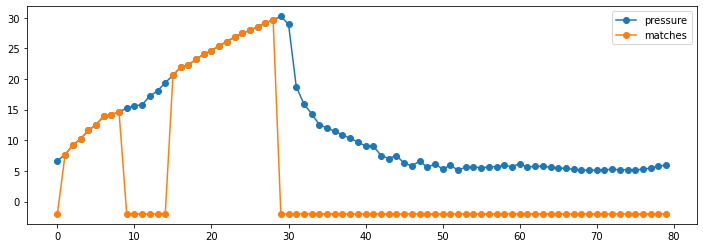

In [38]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds2), '-o', label='matches')
plt.legend()
plt.show()

**As you can see, this only results in a few extra matches on the first half of the triangle, we will have to rework our logic in order to work backwards in the sequence so that we can match some more**

We will rewrite our integral equation:

$I_t = I_{t - 1} + (\epsilon_t - I_{t - 1}) \frac{\Delta_t}{\tau + \Delta_t}$

$\iff I_t = I_{t - 1}(1 - \frac{\Delta_t}{\tau + \Delta_t}) + \epsilon_t\frac{\Delta_t}{\tau + \Delta_t}$

$\iff I_{t-1} = \frac{I_t - \epsilon_t\frac{\Delta_t}{\tau + \Delta_t}}{1 - \frac{\Delta_t}{\tau + \Delta_t}}$

This new equation allows us to propagate integral terms from the future! These future integral terms are then calculated on timesteps for which we found a match and propagated backwards.

## Backwards matching algorithm

1. Pre-calculate `dt2 = dt / (0.5 + dt)` and take a matched position `j+3` and its corresponding pressure.
2. Calculate `integ3 = (u_in[j+3] - kp * (kt - preds[j+3])) / ki`
3. Take 3 random pressure values: (`P0`, `P1`, `P2`). Propagate this integral backwards for 3 timesteps using the equation we just derived. 
4. First: `integ2 = (integ3 - dt2[j + 2] * (kt - preds[j+3]))/(1 - dt2[j + 2])`
5. Calculate `integ1 = (integ2 - dt2[j + 1] * (kt - P2))/(1 - dt2[j + 1])`
6. Calculate `integ0 = (integ1 - dt2[j + 0] * (kt - P1))/(1 - dt2[j + 0])`
7. Calculate `u0 = kp*(kt - P0) + ki*integ0`, `u1 = kp*(kt - P1) + ki*integ1` and `u2 = kp*(kt - P2) + ki*integ2`.
8. Calculate `dU = [u_in[j] - u2, u_in[j + 1] - u3, u_in[j + 2] - u4]`
9. If `(dU[1] - dU[0]) / dt[j] == (dU[2] - dU[1]) / dt[j + 1]`, we have a match.


In [39]:
def match_triangle_backwards(u_in, u_out, timestep, preds, kp, ki, kt):
    dt = np.diff(timestep)
    dt2 = dt / (dt + 0.5)
    in_len = np.sum(1 - u_out)
    found = None
    
    for j in range(32, -1, -1):
        if preds[j] != -999:
            found = None
            continue
            
        if found is None and preds[j + 3] == -999:
            continue
            
        if 0 in [u_in[j], u_in[j + 1], u_in[j + 2], u_in[j + 3]] or 100 in [u_in[j], u_in[j + 1], u_in[j + 2], u_in[j + 3]]:
            found = None
            continue

        if found is None:
            P_known = preds[j + 3]
            val = u_in[j + 3]
        else:
            P_known = P2
            val = found

        P0_found = False
        for P0 in np.arange(PRESSURE_MIN, PRESSURE_MAX + PRESSURE_STEP, PRESSURE_STEP):

            P1 = np.arange(PRESSURE_MIN, PRESSURE_MAX + PRESSURE_STEP, PRESSURE_STEP)

            integ3 = (val - kp * (kt - P_known)) / ki
            integ2 = (integ3 - dt2[j + 2] * (kt - P_known))/(1 - dt2[j + 2])

            integ11 = (integ2 - dt2[j + 1] * (kt - PRESSURE_MIN))/(1 - dt2[j + 1])
            integ01 = (integ11 - dt2[j + 0] * (kt - P1))/(1 - dt2[j + 0])
            u01 = kp*(kt - P0) + ki*integ01
            u11 = kp*(kt - P1) + ki*integ11
            u21 = kp*(kt - PRESSURE_MIN) + ki*integ2
            du1 = [u01 - u_in[j], u11 - u_in[j + 1], u21 - u_in[j+2]]
            x1 = ((du1[1] - du1[0]) / dt[j]) - ((du1[2] - du1[1]) / dt[j + 1])

            integ12 = (integ2 - dt2[j + 1] * (kt - PRESSURE_MIN2))/(1 - dt2[j + 1])
            integ02 = (integ12 - dt2[j + 0] * (kt - P1))/(1 - dt2[j + 0])
            u02 = kp*(kt - P0) + ki*integ02
            u12 = kp*(kt - P1) + ki*integ12
            u22 = kp*(kt - PRESSURE_MIN2) + ki*integ2
            du2 = np.array([u02 - u_in[j], u12 - u_in[j + 1], u22 - u_in[j+2]])
            x2 = ((du2[1] - du2[0]) / dt[j]) - ((du2[2] - du2[1]) / dt[j + 1])

            slope = (x2 - x1)
            x_intersect = -x1 / slope

            if np.min(np.abs(x_intersect - np.round(x_intersect))) < 1e-10:
                pos3 = np.where(np.abs(x_intersect - np.round(x_intersect)) < 1e-10)[0][0]

                P1 = P1[pos3]
                P2 = np.round(x_intersect[pos3]) * PRESSURE_STEP + PRESSURE_MIN

                integ1 = (integ2 - dt2[j + 1] * (kt - P2))/(1 - dt2[j + 1])
                integ0 = (integ1 - dt2[j + 0] * (kt - P1))/(1 - dt2[j + 0])
                u0 = kp*(kt - P0) + ki*integ0
                u1 = kp*(kt - P1) + ki*integ1
                u2 = kp*(kt - P2) + ki*integ2

                if preds[j + 2] == -999:
                    preds[j + 2] = P2
                elif abs(preds[j + 2] - P2) > 1e-10:
                    continue

                if preds[j + 1] == -999: 
                    preds[j + 1] = P1
                elif abs(preds[j + 1] - P1) > 1e-10:
                    continue

                if preds[j] == -999:
                    preds[j] = P0

                found = u2
                P0_found = True
                break

        if not P0_found:
            found = None
            
    return preds

In [40]:
%%time
preds3 = match_triangle_backwards(u_in, u_out, timestep, preds2, kp, ki, kt)

CPU times: user 541 ms, sys: 0 ns, total: 541 ms
Wall time: 542 ms


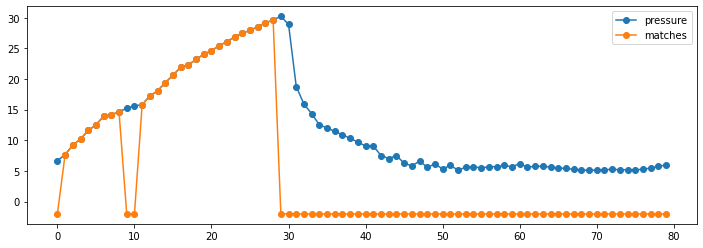

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds2), '-o', label='matches')
plt.legend()
plt.show()

**Woohoo! More matches** Let's show how this also works for linear noise...

In [42]:
# Let's demonstrate the issue on a breath with optimal kp = 0
ID = 6
pressure   = train[train['breath_id'] == ID]['pressure'].values 
timestep   = train[train['breath_id'] == ID]['time_step'].values
u_in       = train[train['breath_id'] == ID]['u_in'].values
u_out      = train[train['breath_id'] == ID]['u_out'].values
preds = match_breath(u_in, u_out, timestep, 2.0, 4.0, 10)

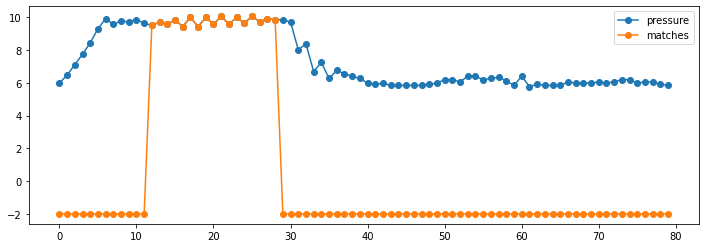

In [43]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds), '-o', label='matches')
plt.legend()
plt.show()

In [44]:
%%time
preds2 = match_triangle_backwards(u_in, u_out, timestep, preds, 2.0, 4.0, 10)

CPU times: user 550 ms, sys: 0 ns, total: 550 ms
Wall time: 550 ms


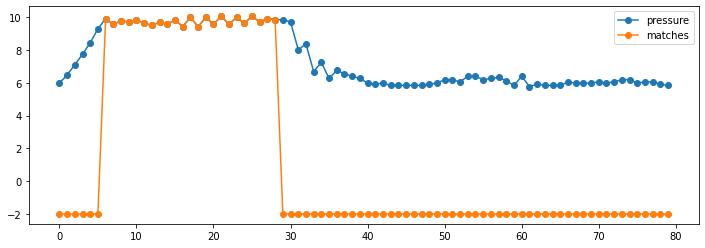

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(pressure, '-o', label='pressure')
plt.plot(np.maximum(-2, preds2), '-o', label='matches')
plt.legend()
plt.show()

# Putting it all together

Below is the combination of all matchers. As one will notice, this code still matches too many values ($72$-$75$% instead of $66$%) and introduces a few errors because of this, but the MAE seems to be around $0.01$ which might be a better trade-off (with a model with LB $0.12$ and $75$% matched with MAE $0.01$, an LB of $0.04$).

During the competition, our code was a lot longer (and a lot less readable) than this. I am currently cleaning the code up and integrating it in this notebook. The number of errors should drop in upcoming versions.

In [46]:
def match(u_in, u_out, timestep, kp, ki, kt):
    preds = match_breath(u_in, u_out, timestep, kp, ki, kt)
    preds = match_triangle(u_in, u_out, timestep, preds, kp, ki, kt)
    preds = match_triangle_backwards(u_in, u_out, timestep, preds, kp, ki, kt)
    
    # Filtering out some potential errors
    preds[u_out == 1] = -999
    preds[(u_in == 0) | (u_in == 100)] = -999
    if kp == 0:
        preds[preds <= 0] = -999
    
    return preds

In [47]:
np.random.seed(42)
params = pickle.load(open('../input/ventilator-foggy/train_parameters.p', 'rb'))
train_breaths = []
for ID in params:
    if params[ID][0] != -1:
        train_breaths.append(ID)
train_breaths = np.random.choice(train_breaths, replace=False, size=1000)

In [48]:
matches = []
ground_truth = []
total = 0

for i, ID in tqdm(enumerate(train_breaths), total=len(train_breaths)):
    
    if params[ID][0] == -1:
        continue
        
    pressure   = train[train['breath_id'] == ID]['pressure'].values 
    timestep   = train[train['breath_id'] == ID]['time_step'].values
    u_in       = train[train['breath_id'] == ID]['u_in'].values
    u_out      = train[train['breath_id'] == ID]['u_out'].values
    preds      = match(u_in, u_out, timestep, params[ID][0], params[ID][1], params[ID][2])
    
    total += np.sum(1 - u_out)
    mask = preds != -999
    matches.extend(preds[mask])
    ground_truth.extend(pressure[:len(preds)][mask])
    
    if i > 0 and i % 100 == 0:
        mae = mean_absolute_error(ground_truth, matches)
        print(f'[iteration #{i}] matched {len(matches)}/{total} values; MAE = {mae}')

  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration #100] matched 2286/3069 values; MAE = 0.007442309364962646
[iteration #200] matched 4642/6097 values; MAE = 0.0068908824211961015
[iteration #300] matched 6869/9126 values; MAE = 0.008566442825860755
[iteration #400] matched 9158/12138 values; MAE = 0.010916100771905721
[iteration #500] matched 11387/15169 values; MAE = 0.012551529090090906
[iteration #600] matched 13598/18191 values; MAE = 0.010655443582198122
[iteration #700] matched 15920/21221 values; MAE = 0.010090477539058494
[iteration #800] matched 18179/24248 values; MAE = 0.011350283127465057
[iteration #900] matched 20464/27290 values; MAE = 0.01263542274499738


In [49]:
np.random.seed(42)
params = pickle.load(open('../input/ventilator-foggy/test_parameters.p', 'rb'))

In [50]:
matches = []
ground_truth = []
total = 0

for i, ID in tqdm(enumerate(test['breath_id'].unique()), total=len(test['breath_id'].unique())):
    
    if params[ID][0] == -1:
        continue
        
    timestep   = test[test['breath_id'] == ID]['time_step'].values
    u_in       = test[test['breath_id'] == ID]['u_in'].values
    u_out      = test[test['breath_id'] == ID]['u_out'].values
    ids        = test[test['breath_id'] == ID].index.values
    
    preds      = match(u_in, u_out, timestep, params[ID][0], params[ID][1], params[ID][2])
    mask = preds != -999
    test_preds.loc[ids[:len(preds)][mask], 'pressure'] = preds[mask]
    

  0%|          | 0/50300 [00:00<?, ?it/s]

In [51]:
test_preds.to_csv('pred_foggy_0.1406_replaced.csv')